In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import roc_curve

In [2]:
vrc_reactivity = pd.read_table("../data/VRC_reactivity_validation.csv", sep=",", index_col = 0)
tile_anno = pd.read_csv("../data/validation_peptides.tsv", sep='\t', index_col = 0)
with open('../data/validation_peptide_probabilities.json') as json_file:
    rf_probabilities = json.load(json_file)

In [3]:
def scoring_tile(pred_vec_rf):
    v = np.array(pred_vec_rf)          
    return(np.mean(v))

In [4]:
ebv = tile_anno[tile_anno["taxon_species"] == "Epstein-Barr virus"]
cmv = tile_anno[tile_anno["taxon_species"] == "Human cytomegalovirus"]
rhino = tile_anno[tile_anno["taxon_species"].str.contains("hinov", na=False)]

In [5]:
ebv_epi_probabilities_rf = {}

for tile in ebv.index:
    ebv_epi_probabilities_rf[tile] = rf_probabilities[tile]
    
cmv_epi_probabilities_rf = {}

for tile in cmv.index:
    if tile in rf_probabilities:
        cmv_epi_probabilities_rf[tile] = rf_probabilities[tile]
        
rhino_epi_probabilities_rf = {}

for tile in rhino.index:
    rhino_epi_probabilities_rf[tile] = rf_probabilities[tile]

# not all predictions for cmv tiles available

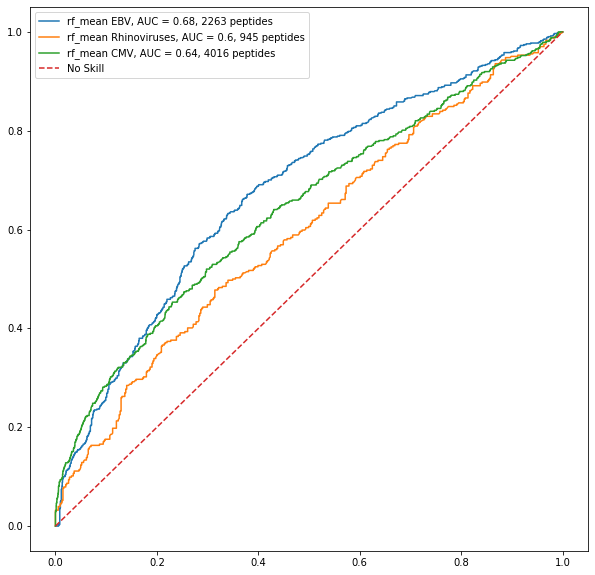

In [19]:
matplotlib.rcParams['figure.figsize'] = [10, 10]

def virus_roc(virus_label, rf_probas):
    cutoff_minsamplesVRC = 8 # 1% of VRC dataset

    comp_df_t = pd.DataFrame({"VRC reactive" : [vrc_reactivity.loc[k,"reactive samples"] >= cutoff_minsamplesVRC for k in rf_probas.keys()]})
    comp_df_t["VRC reactive"] = comp_df_t["VRC reactive"].astype(int)
    score_label = "rf_mean " + virus_label
    comp_df_t[score_label] = [scoring_tile(rf_probas[k]) for k in rf_probas.keys()]
    fpr, tpr, _ = roc_curve(comp_df_t["VRC reactive"], comp_df_t[score_label])
    auc_score = round(metrics.roc_auc_score(comp_df_t["VRC reactive"], comp_df_t[score_label]) ,2)  
    curve_label = score_label + ", AUC = " + str(auc_score) + ", " + str(len(rf_probas)) + " peptides"
    return(fpr, tpr, curve_label)

fig_roc, ax_roc = plt.subplots()    

fpr, tpr, curve_label = virus_roc("EBV", ebv_epi_probabilities_rf)
ax_roc.plot(fpr, tpr, label=curve_label)
sourcedata = pd.DataFrame()
sourcedata["FPR"] = fpr
sourcedata["TPR"] = tpr
sourcedata.to_csv("../data/SourceData/Fig2D_EBV.csv")

fpr, tpr, curve_label = virus_roc("Rhinoviruses", rhino_epi_probabilities_rf)
ax_roc.plot(fpr, tpr, label=curve_label)
sourcedata = pd.DataFrame()
sourcedata["FPR"] = fpr
sourcedata["TPR"] = tpr
sourcedata.to_csv("../data/SourceData/Fig2D_Rhino.csv")

fpr, tpr, curve_label = virus_roc("CMV", cmv_epi_probabilities_rf)
ax_roc.plot(fpr, tpr, label=curve_label)
sourcedata = pd.DataFrame()
sourcedata["FPR"] = fpr
sourcedata["TPR"] = tpr
sourcedata.to_csv("../data/SourceData/Fig2D_CMV.csv")

ax_roc.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
plt.ylim([-0.05, 1.05])
ax_roc.legend()
plt.show()


In [8]:
# fig_roc.savefig('vrc_validation.pdf')  